In [4]:
%config InlineBackend.figure_formats = ['svg']
from maps.basic_map import BasicMap
from scenario import Scenario
from person.random_walk_lost_person import RandomWalkLostPerson
from person.random_walk_searcher import RandomWalkSearcher
from person.finite_horizon_search_party import FiniteHorizonParty, FiniteHorizonPartySearcher
from person.distribution import GridDistribution
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np

In [5]:
latency = 15
dist_map = BasicMap(15, 15)
m = BasicMap(15, 15)
start = (7, 7)
max_steps = 100
dist_missing_person = RandomWalkLostPerson(dist_map)
dist_missing_person.init(start)
dist = GridDistribution(dist_missing_person, dist_map,
                        max_steps + latency + 1, 10000)
dist.run()

In [ ]:
for t in range(0, 100):
    fig, ax = plt.subplots()
    ax.imshow(dist.at_step(t))
    ax.axis('off')
    plt.savefig(f'dist_15x15_{t}.png', dpi=150, bbox_inches='tight')
    plt.close()

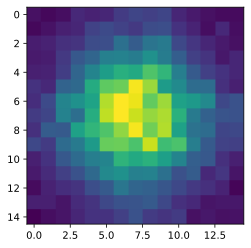

In [3]:
plt.imshow(dist.at_step(30))
plt.show()

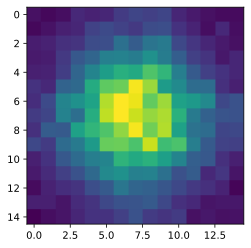

In [4]:
plt.imshow(dist.at_step(30))
plt.show()

28


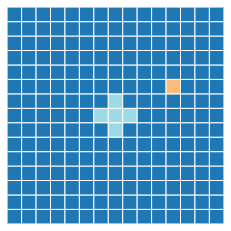

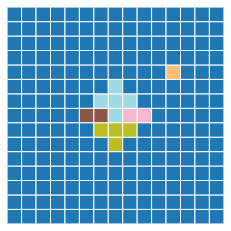

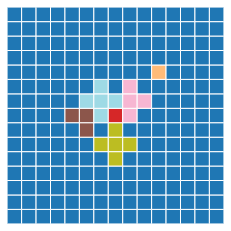

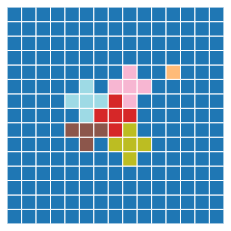

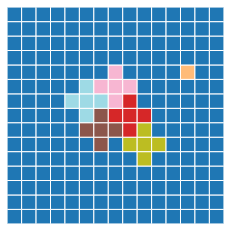

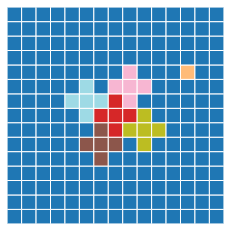

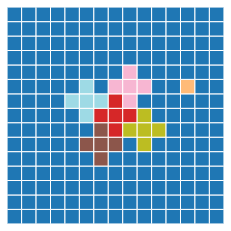

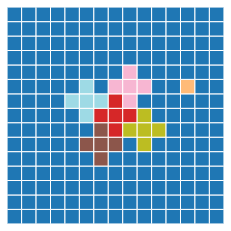

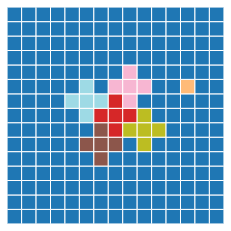

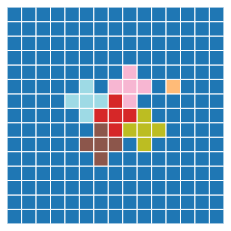

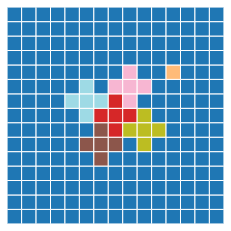

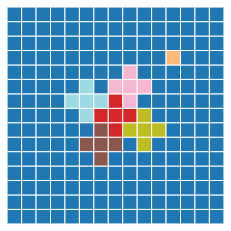

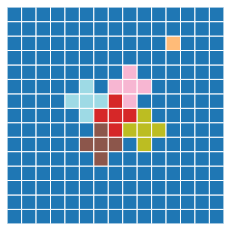

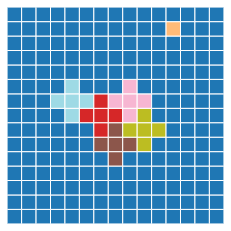

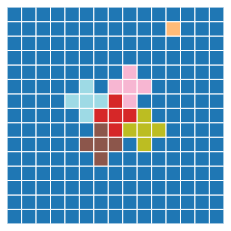

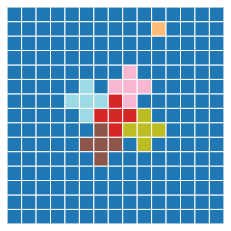

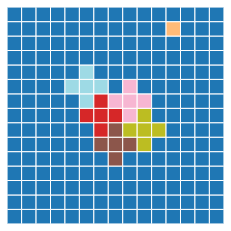

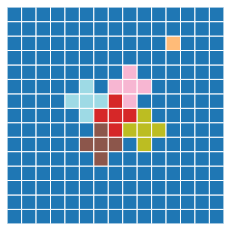

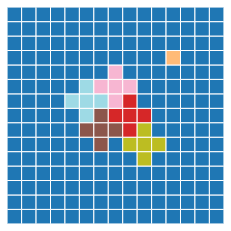

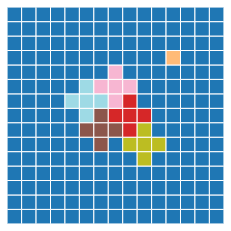

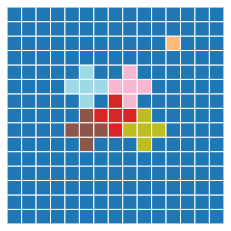

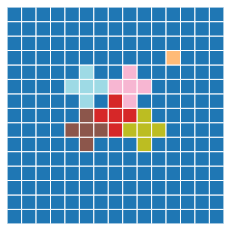

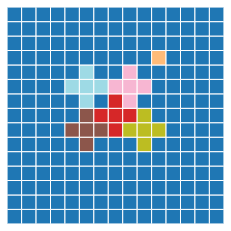

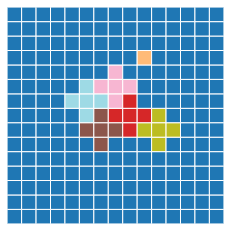

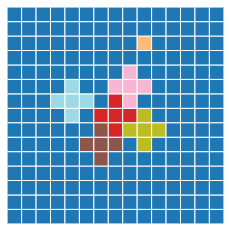

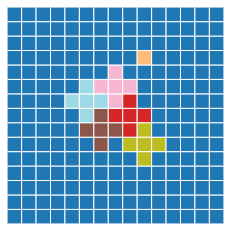

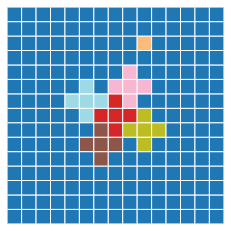

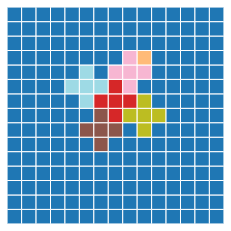

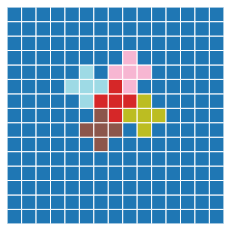

In [11]:
n_searchers = 5
party = FiniteHorizonParty(m, latency, n_searchers, dist)
searchers = [
    FiniteHorizonPartySearcher(party, idx)
    for idx in range(n_searchers)
]
party.init(start)
for searcher in searchers:
    searcher.init()
missing_person = RandomWalkLostPerson(m)
missing_person.init(start)
s = Scenario(m, [missing_person], searchers, latency)
steps = s.simulate(100)
print(steps)

run_id = 2
for step in range(len(searchers[0].history)):
    mesh = np.zeros((15, 15))
    missing_loc = s.lost_persons[0].history[step + latency + 1]
    mesh[missing_loc[0], missing_loc[1]] = 1
    searcher_locs = [
        searcher.history[step]
        for searcher in s.searchers
    ]
    mesh[missing_loc[0], missing_loc[1]] = 1
    for idx, loc in enumerate(searcher_locs):
        for x, y in m.get_visibility(loc):
            mesh[x, y] = idx + 2    

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')
    ax.pcolormesh(mesh, edgecolors='#ffffff', vmin=0, vmax=6, cmap='tab20')
    plt.savefig(f'finite_horizon_run_{run_id}_{step}.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

In [6]:
by_searcher = []
n_runs = 1000
max_searchers = 15
n_steps = 100
N = 15

dist_n = 5
finite_horizon_avg_steps = []
finite_horizon_succeeded = []
finite_horizon_steps_dist = []
for n_searchers in range(1, 1 + max_searchers):
    total = 0
    succeeded = 0
    for idx in trange(n_runs):
        m = BasicMap(N, N)
        party = FiniteHorizonParty(m, latency, n_searchers, dist)
        searchers = [
            FiniteHorizonPartySearcher(party, idx)
            for idx in range(n_searchers)
        ]
        party.init(start)
        for searcher in searchers:
            searcher.init()
        missing_person = RandomWalkLostPerson(m)
        missing_person.init(start)
        s = Scenario(m, [missing_person], searchers, latency)
        steps = s.simulate(n_steps)
        total += steps
        if s.num_rescued > 0:
            succeeded += 1
        if n_searchers == dist_n:
            finite_horizon_steps_dist.append(steps)
    finite_horizon_avg_steps.append(total / n_runs)
    finite_horizon_succeeded.append(succeeded / n_runs)
    
    
random_walk_avg_steps = []
random_walk_succeeded = []
random_walk_steps_dist = []
for n_searchers in range(1, 1 + max_searchers):
    total = 0
    succeeded = 0
    for idx in trange(n_runs):
        m = BasicMap(N, N)
        searchers = [
            RandomWalkSearcher(m)
            for idx in range(n_searchers)
        ]
        party.init(start)
        for searcher in searchers:
            searcher.init(start)
        missing_person = RandomWalkLostPerson(m)
        missing_person.init(start)
        s = Scenario(m, [missing_person], searchers, latency)
        steps = s.simulate(n_steps)
        total += steps
        if s.num_rescued > 0:
            succeeded += 1
        if n_searchers == dist_n:
            random_walk_steps_dist.append(steps)

    random_walk_avg_steps.append(total / n_runs)
    random_walk_succeeded.append(succeeded / n_runs)

100%|██████████| 1000/1000 [00:08<00:00, 123.58it/s]


In [7]:
quadrant_avg_steps = [50.253, 36.838, 26.96, 20.616, 17.663, 17.794, 15.342, 14.593, 12.292, 12.996, 11.754, 11.077, 10.498, 10.021, 10.042
] # from Ben's runs

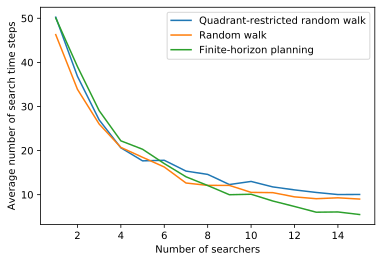

In [13]:
n = range(1, 16)
plt.plot(n, quadrant_avg_steps, label='Quadrant-restricted random walk')
plt.plot(n, random_walk_avg_steps, label='Random walk')
plt.plot(n, finite_horizon_avg_steps, label='Finite-horizon planning')
plt.legend()
plt.xlabel('Number of searchers')
plt.ylabel('Average number of search time steps')
plt.savefig('methods_compared.pdf', bbox_inches='tight')
plt.show()

(array([296.,  28.,  28.,  12.,  10.,   6.,  12.,   4.,  10.,   3.,   3.,
          4.,   3.,   5.,   7.,   1.,   4.,   3.,   1.,  60.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <a list of 20 Patch objects>)

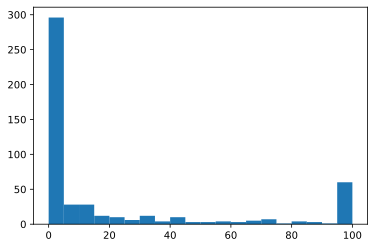

In [28]:
plt.hist(finite_horizon_steps_dist, bins=20)

(array([251.,  52.,  46.,  25.,  16.,   9.,   5.,   7.,   7.,  10.,   5.,
          3.,   5.,   5.,   2.,   3.,   3.,   2.,   3.,  41.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <a list of 20 Patch objects>)

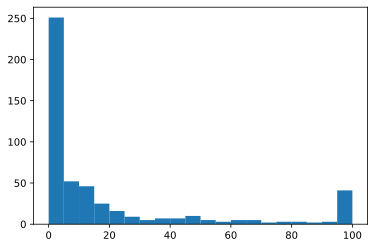

In [29]:
plt.hist(random_walk_steps_dist, bins=20)

20